In [1]:
import torch
from torch.utils.data import Dataset
from torch import nn
import torch.nn.functional as F

from fastai.distributed import *
from fastai.vision.all import *

from pathlib import Path
from functools import partial
import json
import pandas as pd
import matplotlib.pyplot as plt
import math

import ast

In [2]:
device = torch.device('cuda:0')
core_pth = Path('/home/agrawalp2/prepositions'); assert core_pth.exists()
stupd_pth = Path('/mnt/dataset/agrawalp2/stupd_dataset'); assert stupd_pth.exists()

In [3]:
# def map_spatialsenses_to_stupd(o, mapping_dict = spatialsenses_to_stupd):
#     return spatialsenses_to_stupd[o]

def is_static(x):
    static_preps = ['above', 'against_leaning', 'all_over', 'along_position', 'among', 'around_static', 
                   'behind', 'below', 'beside', 'between', 'in_front_of', 'inside', 'on', 'outside']
    
    dynamic_preps = ['against', 'along', 'around', 'by', 'down', 'from', 'into', 'into_crash', 'off', 'onto', 'out_of', 'over', 'through', 'towards', 'up', 'with']
    
    if x in static_preps: return True
    elif x in dynamic_preps: return False
    else: raise Exception("invalid relation input")

def noop(x): return x

# Data

In [4]:
def convert_stupd_bbox_to_spatialsense_bbox(bbox):
    #stupd bbox format = wmin, hmin, w, h
    #spatialsenses bbox format = hmin, hmax, wmin, wmax
    
    wmin, hmin, w,h = bbox
    return (hmin, hmin+h, wmin, wmin+w)

In [5]:
class stupd(Dataset):
    def __init__(self, 
                 annotations_path = stupd_pth/'annotations', 
                 x_tfms: list = None,
                 y_tfms: list = None,
                 frames_per_vid=10,
                ):
        
        f'''
        frames_per_vid: how many frames to consider per video for a data sample x. 
                        Per video, frames_per_vid images will be returned, using a sampling. Eg, if sampling = 'uniform', 10 uniformly spaced images will be returned. 
        
        '''
        
        super().__init__()
        
        self.frames_per_vid = frames_per_vid #only the last frames_per_vid 

        self.coords = []
        self.predicates = [] #y
        
        
        self.classes = set()
        
        
        self.x_tfms = list(x_tfms or [noop]) 
        self.y_tfms = list(y_tfms or [noop]) + [lambda y: self.class2idx[y]]

        for annotations in annotations_path.iterdir():
            
            if annotations.suffix!=".csv": continue
            df = self._process_df(pd.read_csv(annotations))
            
            for i,row in df.iterrows():

                subj_3dcoords = ast.literal_eval(row['subject_position3d'])
                obj_3dcoords = ast.literal_eval(row['object_position3d'])
                subj_2dbbox = ast.literal_eval(row['subject_bbox2d'])
                obj_2dbbox = ast.literal_eval(row['object_bbox2d'])
                
                if is_static(annotations.stem):
                    
                    #the below if else conditions are to process the occasional missing values in the coordinate/bbox dictionaries. 
                    #And also to bring static and dynamic inputs to same shape. Static images are repeated self.frames_per_vid times to emulate as if it were a static video (instead of an image)
                    #if it is dynamic, we first None fill values with empty strings, then sample self.frames_per_vid images from the total 30 frames. 
                    
                    if subj_3dcoords is not None and len(subj_3dcoords):
#                         print(subj_3dcoords)
                        s3d, s2dbbox = subj_3dcoords[0], subj_2dbbox[0] 
                    else: 
                        s3d, s2dbbox =  {"x":0, "y":0, "z":0},[0.,0.,0.,0.]
                    
                    if obj_3dcoords is not None and len(obj_3dcoords):
                        o3d, o2dbbox = obj_3dcoords[0], obj_2dbbox[0]  
                    else: 
                        o3d, o2dbbox = {"x":0, "y":0, "z":0},[0.,0.,0.,0.]
                    
                    coord = [s3d['x'] -o3d['x'],
                             s3d['y'] -o3d['y'],
                             *convert_stupd_bbox_to_spatialsense_bbox(s2dbbox),
                             *convert_stupd_bbox_to_spatialsense_bbox(o2dbbox),
                            ]*self.frames_per_vid
                    
                else:
                    
                    for i in range(len(subj_3dcoords)):
                        if subj_3dcoords[i] is None: subj_3dcoords[i], subj_2dbbox[i] = {"x":0, "y":0, "z":0},[0.,0.,0.,0.]
                        if obj_3dcoords[i] is None:  obj_3dcoords[i],  obj_2dbbox[i] = {"x":0, "y":0, "z":0},[0.,0.,0.,0.]
                   
                    coord = []
                    idxs = self._sample(len(subj_3dcoords)) #uniformly sampled frame indices. 
                    for i in idxs: coord.extend([subj_3dcoords[i]['x'] -obj_3dcoords[i]['x'],
                                                 subj_3dcoords[i]['y'] -obj_3dcoords[i]['y'],
                                                 *convert_stupd_bbox_to_spatialsense_bbox(subj_2dbbox[i]),
                                                 *convert_stupd_bbox_to_spatialsense_bbox(obj_2dbbox[i])])

                self.coords.append(coord)
                self.predicates.append(annotations.stem)
                self.classes.add(annotations.stem)
        
        self.class2idx = {cat:i for i,cat in enumerate(self.classes)}
        self.idx2class = {self.class2idx[cat]:cat for cat in self.class2idx}
        self.c = len(self.classes)  
    
    def __len__(self): return len(self.predicates)
    def __getitem__(self, i):
        coord = self.apply_tfms(self.coords[i], self.x_tfms)
        predicate = self.apply_tfms(self.predicates[i], self.y_tfms)
        
        return (torch.Tensor(coord).type(torch.cuda.FloatTensor), 
                torch.Tensor([predicate]).type(torch.cuda.LongTensor))

    def apply_tfms(self, o, tfms):
        for tfm in tfms: o = tfm(o)
        return o
    
    
    def _sample(self, num_frames=30):
        assert num_frames>=self.frames_per_vid, 'not enough values to select from. Reinitialize with reduced frames_per_vid argument'
        
        idxs = [int((i*num_frames -1)/(self.frames_per_vid-1)) for i in range(self.frames_per_vid) ]
        return idxs
        
    def _process_df(self, df):
        f"this function replace empty values in subject/object category and supercategory columns with an empty string ('') " 
        cols = ['subject_category', 'subject_supercategory', 'object_category', 'object_supercategory']
        
        df[cols] = df[cols].fillna('')
        return df

In [6]:
ds = stupd(frames_per_vid=3)
len(ds)

149776

In [7]:
train_split = 0.8
train_ds, valid_ds = torch.utils.data.random_split(ds, [int(len(ds)*train_split), len(ds) - int(len(ds)*train_split)])
train_ds.c, valid_ds.c = ds.c, ds.c

len(train_ds), len(valid_ds)

(119820, 29956)

In [8]:
train_dl = DataLoader(train_ds, batch_size =512 , shuffle = True, drop_last = True)
valid_dl = DataLoader(valid_ds, batch_size = 1024 , shuffle = True, drop_last = True)

In [9]:
input_dim = len(next(iter(ds))[0]); input_dim

30

# Model

In [10]:
class LinearBlock(nn.Module):
    def __init__(self, input_dim, output_dim, bn=True, relu=True):
        super().__init__()
        
        self.bn = bn
        self.relu = relu
        
        self.linear = nn.Linear(input_dim, output_dim)
        self.batchnorm = nn.BatchNorm1d(output_dim)
        self.ReLU = nn.ReLU()
        
    def forward(self, x):
        x = self.linear(x)
        if self.bn: x = self.batchnorm(x)
        if self.relu: x = self.ReLU(x)
        return x
    
    
class SimpleCoordinateOnlyModel(nn.Module):
    def __init__(self, coord_len, feature_dim, c):
        super().__init__()

        self.layers = nn.Sequential(*[LinearBlock(coord_len, feature_dim)] + [LinearBlock(feature_dim, feature_dim) for _ in range(4)] + [nn.Linear(feature_dim, c)])
    
    def forward(self, x):
        return self.layers(x)

In [11]:
dls = DataLoaders(train_dl, valid_dl)
model = SimpleCoordinateOnlyModel(input_dim,128, ds.c).cuda()
learn = Learner(dls, model = model, loss_func = CrossEntropyLossFlat(), metrics = [accuracy,BalancedAccuracy()])

SuggestedLRs(valley=0.00363078061491251)

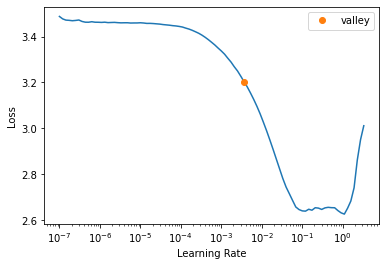

In [12]:
learn.lr_find()

In [13]:
learn.fit_one_cycle(10, 5e-3)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.790622,0.752236,0.757408,0.756617,00:07
1,0.460819,0.661351,0.782429,0.781734,00:07
2,0.384796,0.619111,0.791891,0.790594,00:07
3,0.325182,0.357835,0.875741,0.874782,00:07
4,0.283338,0.411854,0.860284,0.859156,00:07
5,0.242748,0.367774,0.868198,0.867322,00:07
6,0.208976,0.258228,0.909314,0.908617,00:07
7,0.183220,0.199565,0.929452,0.928817,00:07
8,0.159989,0.179600,0.936658,0.936025,00:07
9,0.151008,0.176135,0.938578,0.938043,00:07


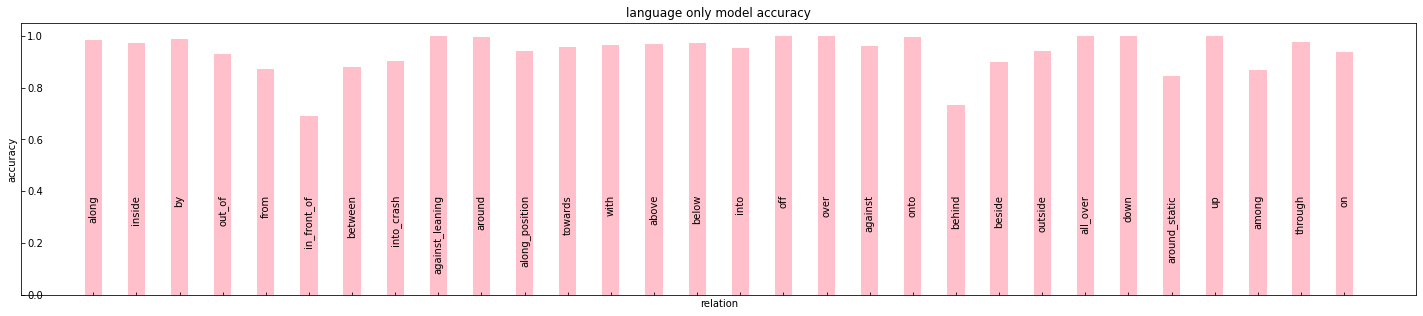

{'along': 0.9852216748768473, 'inside': 0.9723593287265548, 'by': 0.9879638916750251, 'out_of': 0.9295634920634921, 'from': 0.8728991596638656, 'in_front_of': 0.6917599186164801, 'between': 0.8793619142572283, 'into_crash': 0.9034552845528455, 'against_leaning': 0.9980314960629921, 'around': 0.9969604863221885, 'along_position': 0.9423868312757202, 'towards': 0.9583756345177665, 'with': 0.9633123689727463, 'above': 0.9697560975609756, 'below': 0.9725609756097561, 'into': 0.9552845528455285, 'off': 1.0, 'over': 0.9990253411306043, 'against': 0.9624608967674662, 'onto': 0.9949799196787149, 'behind': 0.7333333333333333, 'beside': 0.900709219858156, 'outside': 0.9406952965235174, 'all_over': 1.0, 'down': 1.0, 'around_static': 0.844400396432111, 'up': 1.0, 'among': 0.8699029126213592, 'through': 0.976878612716763, 'on': 0.9397715472481828}


In [14]:
corrects = [0]*ds.c
total = [0]*ds.c

accs = {}
for a,b in valid_dl:
#     res = torch.argmax(model(a,b))
    res = torch.argmax(model(a), dim = 1, keepdim=False)
    
    for gt,r in zip(b, res): 
        total[gt]+=1
        corrects[gt]+=(int(gt==r))

for i in range(len(corrects)):
    accs[ds.idx2class[i]]=corrects[i]/total[i]

fig = plt.figure(figsize = (25, 5))
 
# creating the bar plot
plt.bar(accs.keys(), accs.values(),
        width = 0.4, color='pink')
 
plt.xlabel("relation")
plt.xticks(rotation = 90)
plt.ylabel("accuracy")
plt.title("language only model accuracy")

plt.tick_params(axis="y",direction="in", pad=-22)
plt.tick_params(axis="x",direction="in", pad=-100)
plt.show()


print(accs)

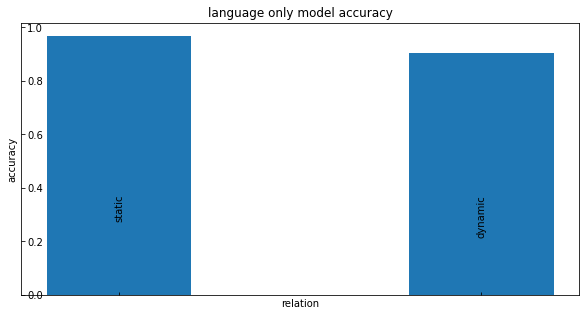

static_accuracy 0.9681254743232988
dynamic_accuracy 0.9049265341400173
0.9344193728922154


In [15]:
corrects = [0]*2
total = [0]*2

accs = [0]*2
for a,b in valid_dl:
#     res = torch.argmax(model(a,b))
    res = torch.argmax(model(a), dim = 1, keepdim=False)
    
    for gt,r in zip(b, res): 
        total[is_static(ds.idx2class[gt.item()])]+=1
        corrects[is_static(ds.idx2class[gt.item()])]+=(int(gt==r))

for i in range(len(corrects)):
    accs[i]=corrects[i]/total[i]

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(['static', 'dynamic'], accs,
        width = 0.4)
 
plt.xlabel("relation")
plt.xticks(rotation = 90)
plt.ylabel("accuracy")
plt.title("language only model accuracy")

plt.tick_params(axis="y",direction="in", pad=-22)
plt.tick_params(axis="x",direction="in", pad=-100)
plt.show()


print('static_accuracy', accs[0])
print('dynamic_accuracy', accs[1])

print(accs[1]*16/30 + accs[0]*14/30)